In [68]:
import argparse
import logging
import pickle

from itertools import repeat
from functools import partial
from multiprocessing import Pool
from tqdm.notebook import tqdm
from redis import Redis
from pathlib import Path
from typing import List, Union, NoReturn, Tuple

import pandas as pd
import numpy as np
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
from libs.lopq.eval import get_cell_histogram

from nearpy import Engine
from nearpy.hashes import RandomBinaryProjections, RandomBinaryProjectionTree, LSHash
from nearpy.distances import EuclideanDistance
from nearpy.storage import RedisStorage
from nearpy.filters import NearestFilter

from nnmodels.hash.helpers import encode_image_to_uuid, decode_image_from_uuid
from libs.lopq import LOPQModel, LOPQSearcherLMDB, LOPQSearcher

import utils

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
db_insert = Redis(host='localhost', port=6379, db=8)
db_complete = Redis(host='localhost', port=6379, db=6)

In [3]:
alg, base_model, descriptor_length = 'MI1', 'resnet18', 256

In [4]:
descriptors_train, uuids_train, descriptors_test, uuids_test = list(), list(), list(), list()

keys = db_complete.keys(f"{base_model}+{descriptor_length}+{alg}*Ph1*")
total = len(keys)
pbar = tqdm(np.arange(total), desc='Loading', total=total)
for key in keys:
    descriptor_bytes = db_complete.get(key)

    if descriptor_bytes:
        descriptor = pickle.loads(descriptor_bytes)
        key_str = key.decode("utf-8")
        if key_str.find("az360") != -1:# != -1 or key_str.find("az340") != -1 or key_str.find("az020") != -1:
            uuids_train.append(key_str)
            descriptors_train.append(descriptor)
        else:
            uuids_test.append(key_str)
            descriptors_test.append(descriptor)
    
    pbar.update()
pbar.close()

#logger.info(f"Loaded {len(descriptors_train)} to hash and {len(descriptors_test)} to search")

In [92]:
d = np.asarray(descriptors_train)
d.shape

(15939, 256)

In [93]:
model = LOPQModel(V=16, M=16, subquantizer_clusters=512)
model.fit(d)

<BarContainer object of 255 artists>

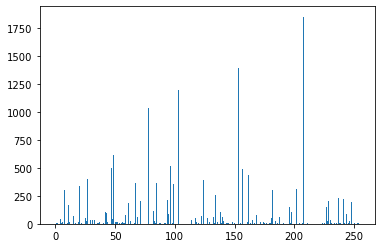

In [94]:
h = get_cell_histogram(d, model)
plt.bar(np.arange(h.shape[0]), h)

In [95]:
searcher = LOPQSearcher(model)
searcher.add_data(d, ids=uuids_train)

In [100]:
list(searcher.search(descriptors_test[2000], with_dists=True)[0])

[Result(id='resnet18+256+MI1+PFP_Ph1_P0608_D01_S001_C2_az360_side1_0011', code=LOPQCode(coarse=(0, 8), fine=(296, 129, 34, 488, 457, 378, 77, 434, 452, 41, 406, 483, 395, 482, 57, 387)), dist=14.328370276517214),
 Result(id='resnet18+256+MI1+PFP_Ph1_P0537_D01_S001_C3_az360_side1_0011', code=LOPQCode(coarse=(0, 8), fine=(410, 325, 144, 243, 330, 186, 22, 419, 383, 232, 300, 221, 451, 17, 129, 72)), dist=19.192640152070837),
 Result(id='resnet18+256+MI1+PFP_Ph1_P0017_D01_S001_C2_az360_side1_0012', code=LOPQCode(coarse=(0, 8), fine=(315, 43, 131, 468, 272, 380, 302, 49, 214, 369, 370, 77, 76, 430, 57, 420)), dist=19.292271531071208),
 Result(id='resnet18+256+MI1+PFP_Ph1_P0480_D01_S001_C2_az360_side1_0015', code=LOPQCode(coarse=(0, 8), fine=(227, 331, 41, 27, 314, 154, 266, 7, 245, 116, 506, 32, 80, 376, 57, 277)), dist=19.409469891174616),
 Result(id='resnet18+256+MI1+PFP_Ph1_P0352_D01_S006_C2_az360_side1_0013', code=LOPQCode(coarse=(0, 8), fine=(191, 360, 42, 331, 431, 295, 192, 49, 50, 

In [97]:
uuids_test[2000]

'resnet18+256+MI1+PFP_Ph1_P0619_D01_S001_C1_az140_side1_0011'

In [87]:
list(s.search(data[16]))

[<map at 0x7f2e06011ee0>, 64]

In [91]:
data = np.random.rand(256, 128)

model = LOPQModel(V=8, M=8, subquantizer_clusters=64)
model.fit(data, n_init=1)


searcher = LOPQSearcher(model)
searcher.add_data(data, np.arange(256))
print(list(searcher.search(data[0])[0]))

Fewer points (18) than dimensions (64) in rotation computation for cluster 0
Fewer points (32) than dimensions (64) in rotation computation for cluster 1
Fewer points (32) than dimensions (64) in rotation computation for cluster 2
Fewer points (20) than dimensions (64) in rotation computation for cluster 3
Fewer points (23) than dimensions (64) in rotation computation for cluster 4
Fewer points (34) than dimensions (64) in rotation computation for cluster 5
Fewer points (32) than dimensions (64) in rotation computation for cluster 7
Fewer points (31) than dimensions (64) in rotation computation for cluster 0
Fewer points (38) than dimensions (64) in rotation computation for cluster 1
Fewer points (22) than dimensions (64) in rotation computation for cluster 2
Fewer points (50) than dimensions (64) in rotation computation for cluster 3
Fewer points (29) than dimensions (64) in rotation computation for cluster 4
Fewer points (34) than dimensions (64) in rotation computation for cluster 5

[Result(id=0, code=(0, LOPQCode(coarse=(0, 7), fine=(16, 48, 23, 7, 30, 28, 29, 4)))), Result(id=153, code=(153, LOPQCode(coarse=(0, 7), fine=(33, 41, 14, 58, 45, 63, 10, 20)))), Result(id=159, code=(159, LOPQCode(coarse=(0, 0), fine=(50, 53, 38, 58, 4, 42, 39, 26)))), Result(id=183, code=(183, LOPQCode(coarse=(0, 4), fine=(16, 30, 40, 8, 59, 28, 63, 10)))), Result(id=113, code=(113, LOPQCode(coarse=(0, 6), fine=(5, 22, 47, 40, 29, 13, 46, 13)))), Result(id=248, code=(248, LOPQCode(coarse=(0, 3), fine=(9, 51, 34, 46, 61, 1, 42, 39)))), Result(id=123, code=(123, LOPQCode(coarse=(0, 3), fine=(46, 33, 24, 0, 1, 3, 50, 36)))), Result(id=47, code=(47, LOPQCode(coarse=(0, 0), fine=(21, 29, 17, 42, 6, 26, 59, 55)))), Result(id=89, code=(89, LOPQCode(coarse=(0, 6), fine=(45, 29, 30, 0, 19, 62, 47, 1)))), Result(id=204, code=(204, LOPQCode(coarse=(0, 4), fine=(34, 53, 0, 47, 7, 18, 7, 7))))]


In [90]:
from libs.lopq import LOPQModel, LOPQSearcher